# Part 1: Partition funciton and propability of a specific configuration (i.e microstate in Statistical Mechanics)

Assuming that the configurations of the system we study are characterized by the variables $ (x_1,x_2, ... ,x_n)$ (the microstates of the system), then the partition function is given by the sum $$ Z = \sum \int dx_1...dx_n e^{-\beta H(x_1,..., x_n)}$$

where the sum or integral indicate discrete or continious microstates. Then the probability of a given microstate is:
$$ p(x_1,x_2,...,x_n) = \frac{e^{-\beta H(x_1,..., x_2)}}{Z} $$

## Part 2: Draw a nandom number of points from a specific probability distribution, in our case the $p(x_1,...x_n)$

# 1) Inverse Transform Sampling

Inverse Transform Sampling is based on the [probability integral transform](https://en.wikipedia.org/wiki/Probability_integral_transform) which states that a random variable defined as $Y = F_X(X)$, where $F_X$ is the cumulative distribution function (CDF) of $X$, has the distribution $\mathcal{U}[0,1]$. The inverse probability integral transform then states that a random variable $\hat{X} = F_X^{-1}(Y)$ where $Y \sim \mathcal{U}[0,1]$ has the same probability distribution as $X$. This allows us to easily sample from probability distributions whose inverse of CDFs can be computed easily. 

Given random variable $X$ with CDF $F_X(x)$ invertable and random variable $Y \sim \mathcal{U}[0,1]$:
- X has the same probability distribution as $\hat{X} = F_X^{-1}(Y)$
- pick y at random
- calculate $F_X^{-1}(y) to generate a sample for x

### Exponential Distribution
The PDF is given by
$$\text{Exp}(\lambda) = \lambda e^{-\lambda x}\,\,\,\forall\,\,x \in [0,\infty)$$   
and the CDF by
F_X(x) = $$P(X \leq x) = 1-e^{-\lambda x}$$  
The inverse is,
$$F_X^{-1}(y) = -\frac{1}{\lambda}\log_e{(1-y)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

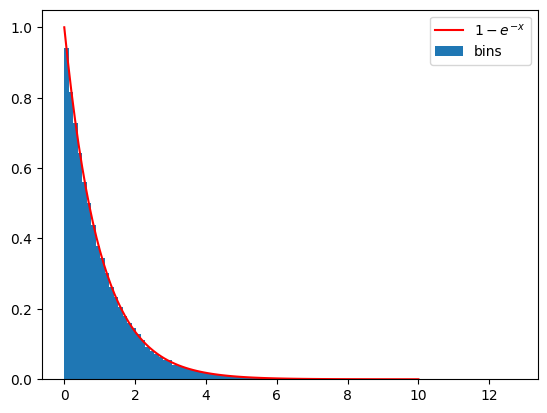

In [2]:
# example: create a sample drawn from the exponential distribution with lambda = 1

n_sample = 10**5
exponential_distribution = lambda x: np.exp(-x)
x_values = np.linspace(0, 10, 100)
y_values = exponential_distribution(x_values)
fig, ax  = plt.subplots()
ax.plot(x_values, y_values, c = 'r', label = '$1-e^{-x}$')

# draw a sample from the exponential distribution
y_uniform_sample = np.random.uniform(0, 1, n_sample)
exponential_inverse = lambda x: -np.log(1-x)
x_sample = exponential_inverse(y_uniform_sample) 
ax.hist(x_sample, density=1, bins = 100, label='bins')
ax.legend()

plt.show()

### Cauchy Distribution
The PDF is given by
$$Cauchy(x_o,\gamma) = \frac{1}{\pi\gamma\Bigg[1+\Big(\frac{x-x_0}{\gamma}\Big)^2\Bigg]}$$   
and the CDF by
$$P(X \leq x) = \frac{1}{2} + \frac{1}{\pi}\tan^{-1}{\Big(\frac{x-x_0}{\gamma}\Big)}$$  
For $Cauchy(0,1)$,
$$F_X^{-1}(y) = \tan{\Bigg[\pi\Big(y-\frac{1}{2}\Big)\Bigg]}$$

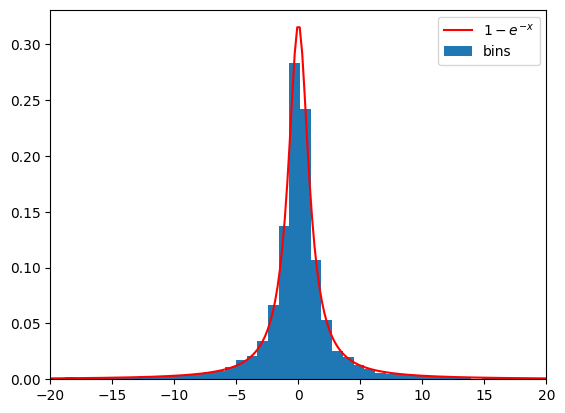

In [3]:
# example: create a sample drawn from the Cauchy distribution with x0 = 1, gamma =1

cauchy_distribution = lambda x: 1./np.pi/(1+x**2)
x_values = np.linspace(-100, 100, 1000)
y_values = cauchy_distribution(x_values)
fig, ax  = plt.subplots()
ax.plot(x_values, y_values, c = 'r', label = '$1-e^{-x}$')

# draw a sample from the Cauchy distribution
n_sample = 10**4
y_uniform_sample = np.random.uniform(0, 1, n_sample)
cauchy_inverse = lambda x: np.tan(np.pi*(x-0.5))
x_sample = cauchy_inverse(y_uniform_sample) 
ax.hist(x_sample, density=1, bins = n_sample, label='bins')
ax.legend()
ax.set_xlim(-20, 20)

plt.show()

## 2) Metropolis Hastings
This is an example of a Markov Chain Monte Carlo (MCMC). In its simplified version for any target distribution $p(x)$  and a proposal distribution $q(x)$ (usually a normal distribution) the Metropolis-Hastings algorithm proceeds as follows:
* Start at some $x_t = x_0$.
* Sample $x_{\text{new}} \sim q(x|x_t)$
* $\alpha = \frac{p(x_{\text{new}})}{p(x_t)}$
* Sample $k_i \sim Uniform[0,1]$
    * if $k_i < \alpha$ then $x_{t+1} = x_{\text{new}}$
    * else $x_{t+1} = x_t$
* The sequence of examples $\{ x_t \} _{t=1,\dots, N}$, is a sample drawn from the target distribution $p(x)$

In [4]:
def metropolis_hastings_one_dimension(target_distribution, n_sample, x_start, 
                         lower_limit = float('-inf'), upper_limit = float('inf'),
                         ):
    '''Application of the Metropolis Hastings Algorithm to sample from one-dimensional distribution
    
    Args:
    target_distribution: function of the distribution we want to sample from
    n_sample: number of samples
    x_start: starting point of sample
    lower_limit: low limit of the domain of the distribution
    upper_limit: upper limit of the domain of the distribution 
    
    returns:
    samples: np.array() of samples from the distribution of length n_sample
    '''

    samples = np.zeros(n_sample)

    x_current = x_start
    
    for i in range(n_sample):
        
        # use a normal distribution around x_current as the proposal distribution
        x_proposed = x_current + np.random.normal(0, 1)
        
        # check if proposed x is outside of the domain of the target distribution
        if x_proposed < lower_limit or x_proposed > upper_limit:
            samples[i] = x_current
            continue

        ratio = target_distribution(x_proposed)/ target_distribution(x_current)
        u = np.random.uniform(0, 1)
        
        if u < ratio:
            x_current = x_proposed
        
        samples[i] = x_current
    
    return samples

def create_sample(distribution, n_sample, a, b,
                  x_start, lower_limit = float('-inf'), upper_limit = float('inf')
                  ):

    x_values = np.linspace(a, b, n_sample)
    y_values = distribution(x_values)  

    samples = metropolis_hastings_one_dimension(distribution, n_sample, x_start, lower_limit, upper_limit)
    
    return x_values, y_values, samples

def plot_distribution_sample(x_values, y_values, samples, plot_title):

    plt.plot(x_values, y_values, c = 'r', label = 'Distribution')
    plt.hist(samples, bins=len(samples)//100, density=True, label='Samples')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(plot_title)
    plt.legend()
    plt.show()

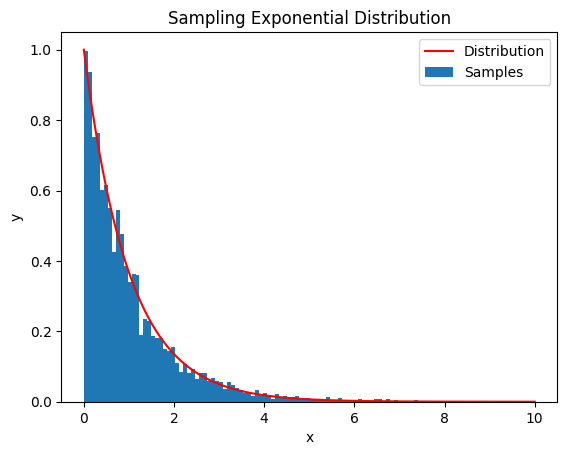

In [5]:
distribution = lambda x: np.exp(-x)
x_values, y_values, samples = create_sample(distribution, 10000, 0, 10, 1, lower_limit=0)
plot_distribution_sample(x_values, y_values, samples, plot_title='Sampling Exponential Distribution')

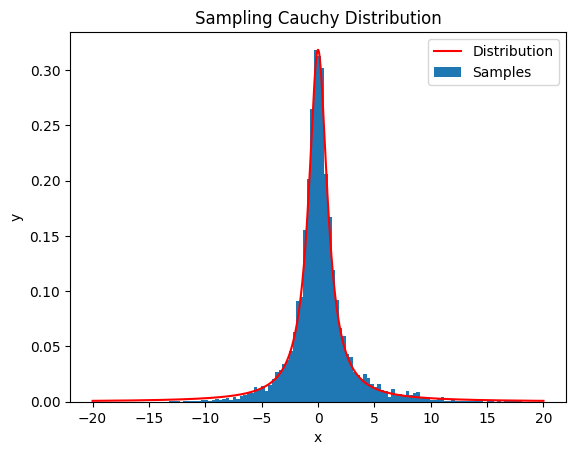

In [7]:
distribution =  lambda x: 1./np.pi/(1+x**2)
x_values, y_values, samples = create_sample(distribution, 10000, -20, 20, 0)
plot_distribution_sample(x_values, y_values, samples, plot_title='Sampling Cauchy Distribution')

# Independency of Samples
To check whether or not two samples are drawn from the same distribution we can perform a Kolmogorov–Smirnov test by calculating their cumulative distribution function and compare.